In [26]:
import tensorflow as tf


# Check tensorflow version
print("Using Tensorflow %s\n" % (tf.__version__))

Using Tensorflow 2.7.0



In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

from sklearn import metrics
import math
import numpy as np
from tensorflow.keras.models import Model

In [29]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

restore_model = False
pixels = 500

if (restore_model):    
    model = load_model('models/class_only/checkpoints/epoch_31-0.65.h5')
else:

    # creating with 500 pixels
    conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(pixels, pixels,3))

    conv_base.trainable = False

    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Conv2D(1024, (3, 3), padding="same", strides=(1, 1), activation="relu", name="ClassConv"))
    model.add(layers.GlobalAveragePooling2D(name="GAP"))
    model.add(layers.Dense(2048, activation='relu',name='fc-1'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, activation='relu',name='fc-2'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(40, activation="softmax", name="class"))    

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 16, 16, 1280)     2257984   
 ional)                                                          
                                                                 
 ClassConv (Conv2D)          (None, 16, 16, 1024)      11797504  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 1024)             0         
 )                                                               
                                                                 
 fc-1 (Dense)                (None, 2048)              2099200   
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 fc-2 (Dense)                (None, 1024)             

In [30]:
all_amp_layer_weights = model.layers[-1].get_weights()[0]

all_amp_layer_weights.shape



(1024, 40)

In [31]:
cam_shape = tuple(model.get_layer("ClassConv").output.get_shape().as_list()[1:])
cam_shape

(16, 16, 1024)

In [32]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10, zoom_range= [0.9,1.1])
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
BATCH_SIZE = 64


train_generator = train_datagen.flow_from_directory("/content/gdrive/MyDrive/standford40_tvt_ds_seed_13/train", batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical')
valid_generator = valid_datagen.flow_from_directory("/content/gdrive/MyDrive/standford40_tvt_ds_seed_13/validation", batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical', shuffle=False)
test_generator = test_datagen.flow_from_directory("/content/gdrive/MyDrive/standford40_tvt_ds_seed_13/test", batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical', shuffle=False)

y_true = test_generator.classes

train_m = len(train_generator.classes)
test_m = len(test_generator.classes)
valid_m = len(valid_generator.classes)


mapping = dict()
for activity, idx in train_generator.class_indices.items():
    mapping[idx] = activity

train_steps = math.ceil(train_m/BATCH_SIZE)
test_steps = math.ceil(test_m/BATCH_SIZE)
valid_steps = math.ceil(valid_m/BATCH_SIZE)


Found 6665 images belonging to 40 classes.
Found 1417 images belonging to 40 classes.
Found 1450 images belonging to 40 classes.


In [34]:
print(train_steps)

105


In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


filepath = "models/class_only/checkpoints/epoch_{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

callback = tf.keras.callbacks.EarlyStopping(monitor='classification_loss', patience=5)

logdir = "models/class_only/logs"

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [36]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4), metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [37]:
prev_epochs = 0
epochs = 32

In [38]:
history = model.fit_generator(train_generator, steps_per_epoch=train_steps, initial_epoch=prev_epochs, epochs=epochs, validation_data=valid_generator, validation_steps=valid_steps, callbacks=[tensorboard_callback, checkpoint])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/32
105/105 [==============================] - ETA: 0s - loss: 3.4348 - acc: 0.1001 
Epoch 00001: val_loss improved from inf to 2.72998, saving model to models/class_only/checkpoints/epoch_01-2.73.h5
105/105 [==============================] - 1735s 16s/step - loss: 3.4348 - acc: 0.1001 - val_loss: 2.7300 - val_acc: 0.3430
Epoch 2/32
105/105 [==============================] - ETA: 0s - loss: 2.5047 - acc: 0.3242
Epoch 00002: val_loss improved from 2.72998 to 1.88318, saving model to models/class_only/checkpoints/epoch_02-1.88.h5
105/105 [==============================] - 453s 4s/step - loss: 2.5047 - acc: 0.3242 - val_loss: 1.8832 - val_acc: 0.5208
Epoch 3/32
105/105 [==============================] - ETA: 0s - loss: 1.8885 - acc: 0.4758
Epoch 00003: val_loss improved from 1.88318 to 1.52746, saving model to models/class_only/checkpoints/epoch_03-1.53.h5
105/105 [==============================] - 404s 4s/step - loss: 1.8885 - acc: 0.4758 - val_loss: 1.5275 - val_acc: 0.5822
Epoch


Saving Model




In [39]:
model.save('standford40_tvt_ds_seed_13_mobileNet_ann_added_04.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [40]:
import shutil
shutil.copy('/content/standford40_tvt_ds_seed_13_mobileNet_ann_added_04.h5','/content/gdrive/MyDrive/')

'/content/gdrive/MyDrive/standford40_tvt_ds_seed_13_mobileNet_ann_added_04.h5'

**Performing Analysis**

In [41]:
 score = model.evaluate_generator(test_generator, test_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [42]:
score

[1.2446630001068115, 0.7296551465988159]

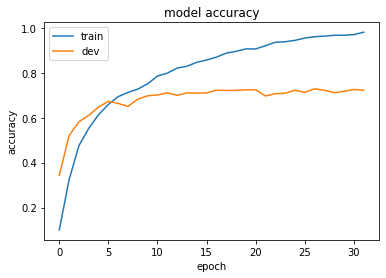

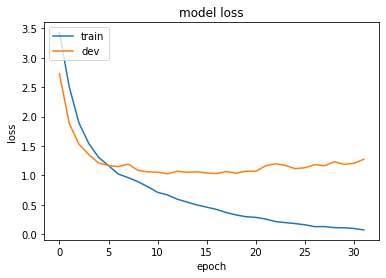

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [44]:
predictions = model.predict_generator(test_generator, test_steps)
predictions = predictions.argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [45]:
(y_true == predictions).mean()

0.7296551724137931

In [46]:
test_labels = test_generator.classes;
test_generator.class_indices;

0.7296551724137931
              precision    recall  f1-score   support

           0       0.67      0.68      0.67        47
           1       0.44      0.92      0.60        37
           2       0.75      0.58      0.66        36
           3       0.86      0.89      0.88        28
           4       0.93      0.91      0.92        46
           5       0.63      0.84      0.72        37
           6       0.93      0.82      0.87        33
           7       0.79      0.52      0.62        29
           8       0.64      0.35      0.45        40
           9       0.68      0.83      0.75        23
          10       0.77      0.94      0.85        47
          11       0.94      0.72      0.82        43
          12       0.94      0.84      0.89        38
          13       0.81      0.55      0.66        38
          14       0.82      0.98      0.89        43
          15       0.75      0.79      0.77        48
          16       0.73      0.87      0.79        31
        

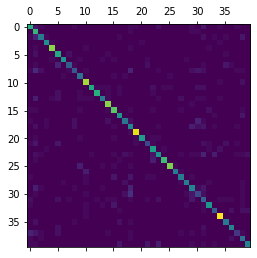

In [47]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(accuracy_score(test_labels,predictions));
print(classification_report(test_labels,predictions));
cm_train = confusion_matrix(test_labels,predictions);
plt.matshow(cm_train);